In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras import backend as K
import warnings
from tensorflow.keras.utils import get_custom_objects
warnings.filterwarnings("ignore")
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)})

- baseline보다 data columns 더 사용
- mish함수 사용
- 50 -> 20개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용
- layer 층을 늘림 (5*5) 까지 줄임
- loss가 줄지 않을 경우 learning rate 를 줄이는 method 사용

In [2]:
%%time
def trainGenerator():
    
    train_path = 'data/train'
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        
        dataset = np.load(file)
        
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:14]
        
        if (cutoff_labels > 0).sum() < 20:
            
            continue

        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,14]),tf.TensorShape([40,40,1])))
train_dataset = train_dataset.batch(512).prefetch(1)

Wall time: 77.8 ms


In [3]:
train_dataset

<DatasetV1Adapter shapes: ((None, 40, 40, 14), (None, 40, 40, 1)), types: (tf.float32, tf.float32)>

In [4]:
%%time
test_path = 'data/test'
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    
    data = np.load(file)
    
    X_test.append(data[:,:,:])
                  
X_test = np.array(X_test)

test: 100%|███████████████████████████████████████████████████████████████████████| 2416/2416 [00:03<00:00, 646.51it/s]


Wall time: 4.08 s


In [5]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load('data/train/subset_010462_01.npy')

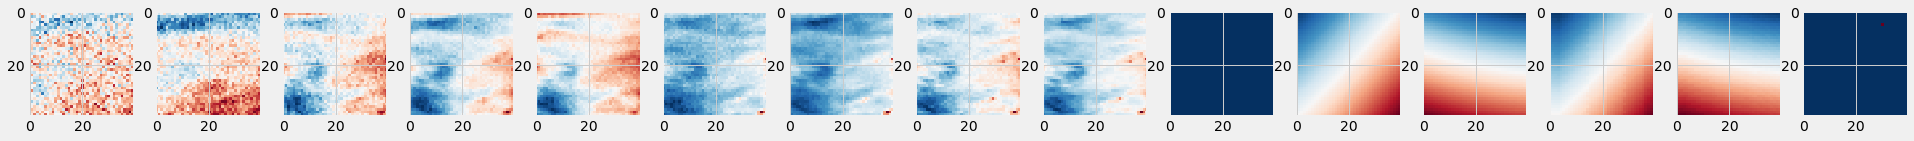

In [6]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(14):
    plt.subplot(1,15,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,15,15)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [7]:
def build_model(input_layer, start_neurons):
    
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same",kernel_initializer='he_normal')(input_layer)
    conv1 = Activation('mish')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="mish", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('mish')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", kernel_initializer='he_normal')(pool1)
    conv2 = Activation('mish')(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('mish')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", kernel_initializer='he_normal')(pool2)
    conv3 = Activation('mish')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('mish')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)
    
    convm = Conv2D(start_neurons * 8, (3, 3), padding="same")(pool3)
    convm = Activation('mish')(convm)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.2)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", kernel_initializer='he_normal')(uconv3)
    uconv3 = Activation('mish')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('mish')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.2)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", kernel_initializer='he_normal')(uconv2)
    uconv2 = Activation('mish')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('mish')(uconv2)


    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.2)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", kernel_initializer='he_normal')(uconv1)
    uconv1 = Activation('mish')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('mish')(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='mish')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 14))
output_layer = build_model(input_layer, 32)
model = Model(input_layer, output_layer)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 14)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 32)   4064        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 40, 40, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 32)   9248        activation[0][0]                 
______________________________________________________________________________________________

In [10]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [11]:
model.compile(loss="mae", optimizer="nadam", metrics=[maeOverFscore_keras, fscore_keras])
model_history = model.fit(train_dataset, epochs = 5, verbose=1)

Epoch 1/5
82/82 [==============================] - 788s 10s/step - loss: 0.2948 - maeOverFscore_keras: 77.8980 - fscore_keras: 0.0770
Epoch 2/5
82/82 [==============================] - 782s 10s/step - loss: 0.2543 - maeOverFscore_keras: 5.2825 - fscore_keras: 0.4372
Epoch 3/5
82/82 [==============================] - 800s 10s/step - loss: 0.2349 - maeOverFscore_keras: 3.2237 - fscore_keras: 0.5552
Epoch 4/5
82/82 [==============================] - 807s 10s/step - loss: 0.2278 - maeOverFscore_keras: 3.0832 - fscore_keras: 0.5661
Epoch 5/5
82/82 [==============================] - 806s 10s/step - loss: 0.2214 - maeOverFscore_keras: 2.9081 - fscore_keras: 0.5835


In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor='loss')

model_history = model.fit(train_dataset, epochs = 7 , verbose=1,callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='maeOverFscore_keras', 
                                factor = 0.8, patience = 1, min_lr = 3e-5, verbose = 1),early_stop])

Epoch 1/7
82/82 [==============================] - 843s 10s/step - loss: 0.1738 - maeOverFscore_keras: 1.8296 - fscore_keras: 0.7397
Epoch 2/7
82/82 [==============================] - 894s 11s/step - loss: 0.1738 - maeOverFscore_keras: 1.8190 - fscore_keras: 0.7414
Epoch 3/7
82/82 [==============================] - 888s 11s/step - loss: 0.1735 - maeOverFscore_keras: 1.8155 - fscore_keras: 0.7418
Epoch 4/7
82/82 [==============================] - 916s 11s/step - loss: 0.1734 - maeOverFscore_keras: 1.8134 - fscore_keras: 0.7421
Epoch 5/7
82/82 [==============================] - 893s 11s/step - loss: 0.1731 - maeOverFscore_keras: 1.8088 - fscore_keras: 0.7426
Epoch 6/7
82/82 [==============================] - 877s 11s/step - loss: 0.1729 - maeOverFscore_keras: 1.8069 - fscore_keras: 0.7429
Epoch 7/7
82/82 [==============================] - 855s 10s/step - loss: 0.1728 - maeOverFscore_keras: 1.8047 - fscore_keras: 0.7430


In [15]:
pred = model.predict(X_test)
submission = pd.read_csv('data/sample_submission.csv')
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('Dacon_baseline1.csv', index = False)

## conclusion

- dropout을 줄인 이유인지 loss와 mae가 줄었지만 결과는 2.1정도 나옴
- 1 epoch당 약 15분정도 걸림